Assignment Details:

1.       Explore the data-set and find the relationship of features (x1...x4) to target (y).
2.       Create a model that can predict 'y' given features.
3.       Select the best model using various model selection techniques.
4.       Tune the hyper-parameters for best possible classification metrics.

Importing required packages for data preprocessing, model building, model evaluation

Importing csv data

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split # train test split
from sklearn.preprocessing import StandardScaler # feature scaling

from sklearn.dummy import DummyClassifier # Baseline prediction
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from HyperclassifierSearch import HyperclassifierSearch # Hyperparameter tuning - Gridsearch
from sklearn import metrics # model evaluation
from sklearn.inspection import PartialDependenceDisplay as PDP # explain model features
from scipy.stats import zscore # outlier treatement
import matplotlib.pyplot as plt # plots
import seaborn as sns # plots
import pickle # model dump

import warnings
warnings.filterwarnings('ignore')

# import csv data
df = pd.read_csv('ZI_Assignment_Data_Set.csv', index_col=False)
df.head()

,Unnamed: 0,x1,x2,x3,x4,y
0,0,-4.326537,-0.552119,5.847767,1,0
1,1,0.970155,1.980708,-2.049272,0,1
2,2,9.963707,5.158819,-4.560561,0,1
3,3,12.748365,-9.561007,-4.742933,0,1
4,4,4.648604,-4.312924,9.130622,1,0


Removing the index column thats imported while importing data from CSV

In [3]:
print(df.columns)
df.drop(columns='Unnamed: 0',inplace=True)
df.head()

Index(['Unnamed: 0', 'x1', 'x2', 'x3', 'x4', 'y'], dtype='object')


,x1,x2,x3,x4,y
0,-4.326537,-0.552119,5.847767,1,0
1,0.970155,1.980708,-2.049272,0,1
2,9.963707,5.158819,-4.560561,0,1
3,12.748365,-9.561007,-4.742933,0,1
4,4.648604,-4.312924,9.130622,1,0


Checking dataset details

Target event rate

In [4]:
print(df.isna().sum(),'\n\n')
# df = df.where((pd.notnull(df)),'') # replace NaN values if any
# how would replace null values across columns, check that write codes

print(df.info(),'\n\n')
print(df.describe(),'\n\n')

print("Unique values in target")
print(df.y.value_counts())

print("Event rate for target : \n",df.y.value_counts()/df.shape[0])

x1    0
x2    0
x3    0
x4    0
y     0
dtype: int64 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   x1      100000 non-null  float64
 1   x2      100000 non-null  float64
 2   x3      100000 non-null  float64
 3   x4      100000 non-null  int64  
 4   y       100000 non-null  int64  
dtypes: float64(3), int64(2)
memory usage: 3.8 MB
None 


                  x1             x2             x3             x4  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean        7.502228       0.029169      -0.002664       0.499020   
std         5.603133       5.770298       5.766394       0.500002   
min       -15.025862      -9.999766      -9.999965       0.000000   
25%         3.695063      -4.959535      -4.992872       0.000000   
50%         7.520307       0.064876       0.008822       0.000000   
75%        11.328508       5

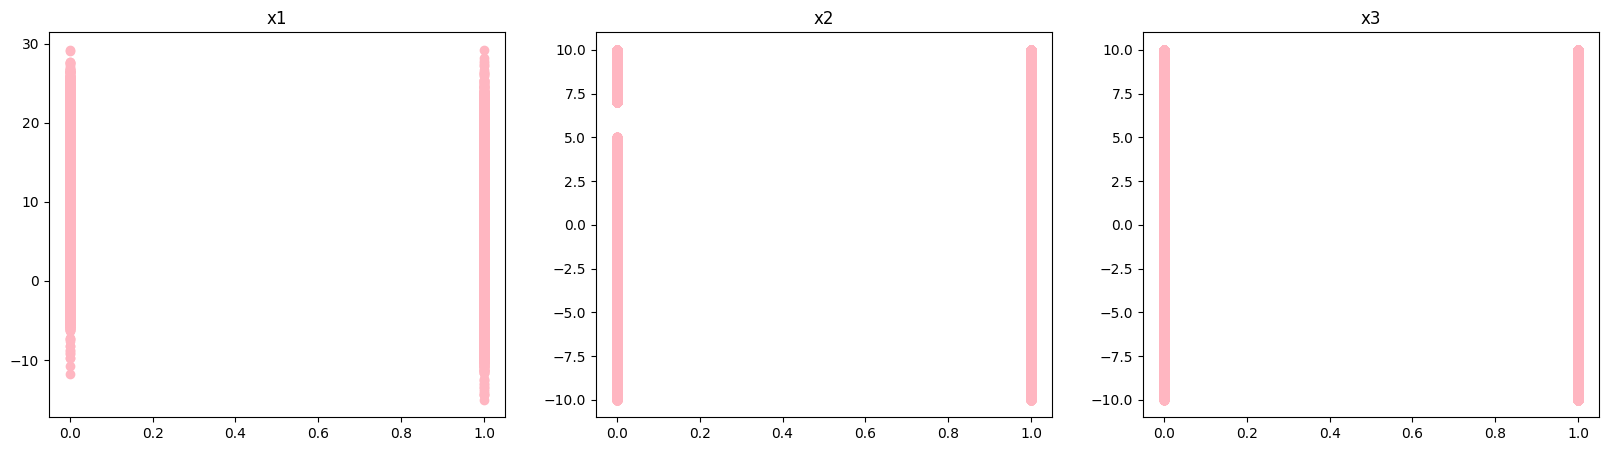

y,0,1
x4,,
0,0.225220,0.275760
1,0.112390,0.386630


In [8]:
fig, ax = plt.subplots(1,3, figsize=(20,5))

ax[0].scatter(df.y,df.x1, color='lightpink')
ax[0].set(title='x1')
ax[1].scatter(df.y,df.x2, color='lightpink')
ax[1].set(title='x2')
ax[2].scatter(df.y,df.x3, color='lightpink')
ax[2].set(title='x3')
plt.show()

# cross tab data for categorical variables
pd.crosstab(df.x4,df.y,normalize=True).style

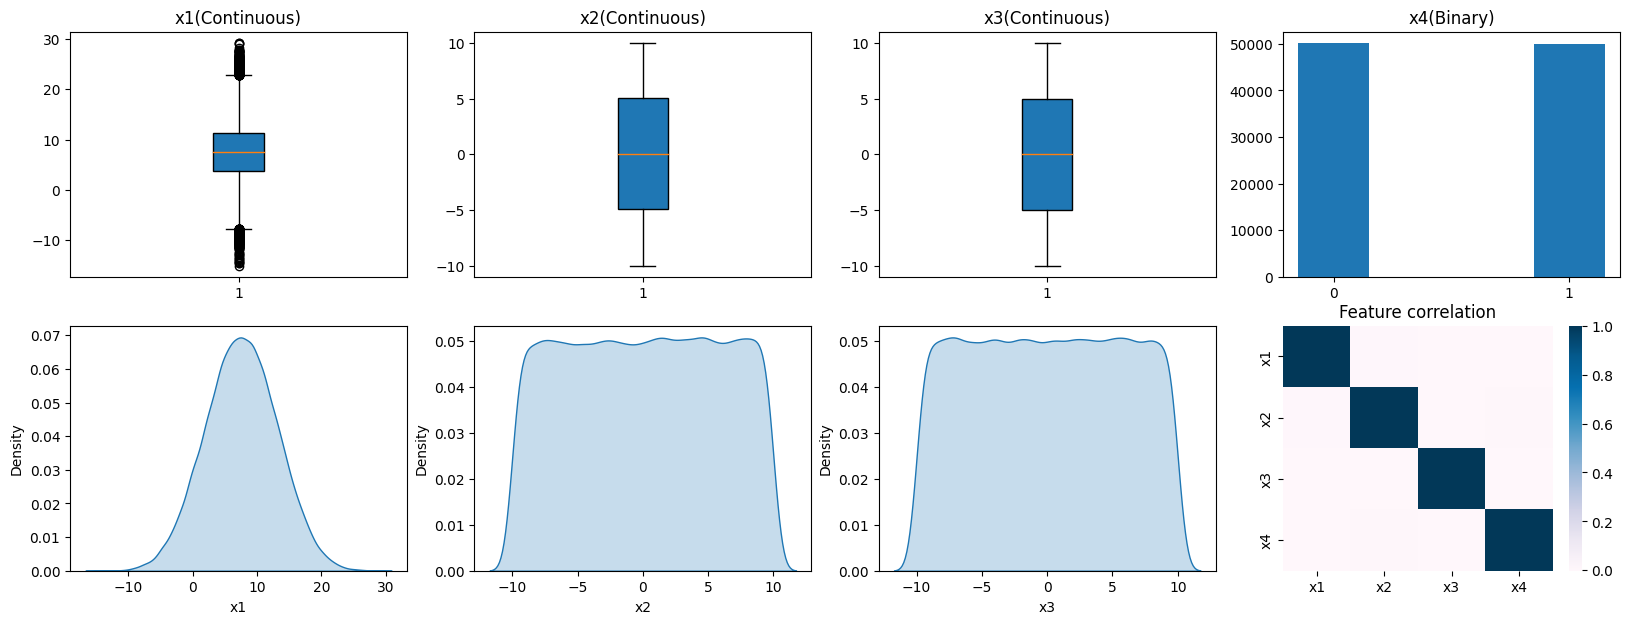

In [9]:
# checking for correleation between features & checking outliers

fig, ax = plt.subplots(2,4, figsize=(20,7))

ax[0,0].boxplot(df.x1,patch_artist=True, showfliers=True)
ax[0,0].set(title='x1(Continuous)')
ax[0,1].boxplot(df.x2,patch_artist=True, showfliers=True)
ax[0,1].set(title='x2(Continuous)')
ax[0,2].boxplot(df.x3,patch_artist=True, showfliers=True)
ax[0,2].set(title='x3(Continuous)')

ax[0,3].bar(df.x4.value_counts().index,df.x4.value_counts().values,width=0.3)
ax[0,3].set(title='x4(Binary)',xticks=np.arange(2))

sns.kdeplot(ax=ax[1,0],data=df['x1'],fill=True)
sns.kdeplot(ax=ax[1,1],data=df['x2'],fill=True)
sns.kdeplot(ax=ax[1,2],data=df['x3'],fill=True)

corr = df.loc[:,df.columns != 'y'].corr()
sns.heatmap(ax=ax[1,3],data=corr,annot=False, cmap='PuBu')
ax[1,3].set(title='Feature correlation')

plt.show()

Splitting our dataset to train and test dataset, maintaining 20% for test and 80% for train

Y is our target variable
x1, x2, x3, x4 are the feature variables

In [10]:
# train test split

x = df.loc[:,df.columns != 'y']
y = df['y'] # target variable
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=3)

Looking into above data distribution, we see that x1 feature has some outliers.

Given that x1 is normally distributed, I had followed Z score method to treat outliers.

The following step is to cap the outliers.

In [11]:
# capping outliers for x1

print("Stats before capping outliers")
print(f'Mean : {x_train.x1.mean():.2f}',f'\nMedian : {x_train.x1.median():.2f}',f'\nMin : {x_train.x1.min():.2f}',f'\nMax : {x_train.x1.max():.2f}')

x_train_old = x_train.copy()
x_train.reset_index(drop=True, inplace=True)
zscores = zscore(x_train.x1)
floor_outliers_index, ceil_outliers_index = np.array(np.where(zscores < -2.7)).ravel().tolist(), np.array(np.where(zscores > 2.7)).ravel().tolist()
inliers_data = x_train[~x_train.index.isin(floor_outliers_index+ceil_outliers_index)]
inlier_min, inlier_max = inliers_data.x1.min(), inliers_data.x1.max()

x_train.loc[x_train.index.isin(floor_outliers_index),['x1']] = inlier_min
x_train.loc[x_train.index.isin(ceil_outliers_index),['x1']] = inlier_max

print("\nStats after capping outliers")
print(f'Mean : {x_train.x1.mean():.2f}',f'\nMedian : {x_train.x1.median():.2f}',f'\nMin : {x_train.x1.min():.2f}',f'\nMax : {x_train.x1.max():.2f}')
print(f'\nInlier data min :{inlier_min:.2f}',f'\nInlier data max :{inlier_max:.2f}')


Stats before capping outliers
Mean : 7.50 
Median : 7.53 
Min : -15.03 
Max : 29.23

Stats after capping outliers
Mean : 7.50 
Median : 7.53 
Min : -7.62 
Max : 22.62

Inlier data min :-7.62 
Inlier data max :22.62


Box plot to compare distribution Before and after capping outliers

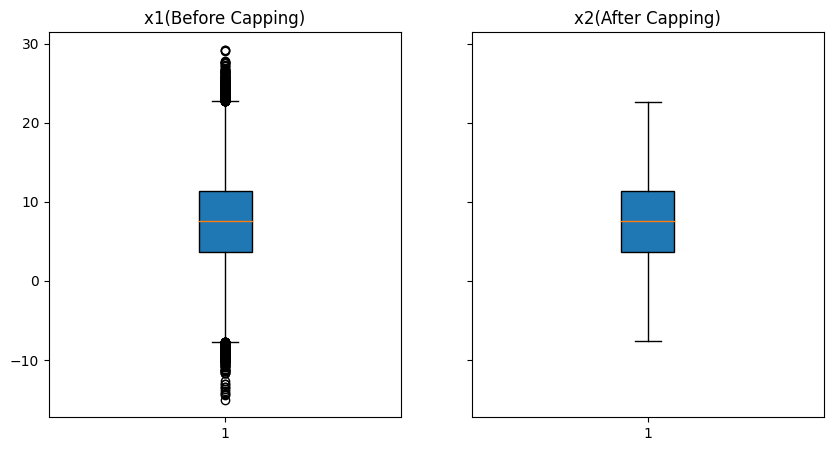

In [12]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(10,5))

ax[0].boxplot(x_train_old.x1,patch_artist=True, showfliers=True)
ax[0].set(title='x1(Before Capping)')
ax[1].boxplot(x_train.x1,patch_artist=True, showfliers=True)
ax[1].set(title='x2(After Capping)')

plt.show()

Feature scaling technique - Standard scaler technique is used ( Data would follow this pattern, mean = 0, std = 1)

In [13]:
# feature scaling

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

defining function for performance evaluation for our models

In [14]:
# function for performance evaluation metrics for models

def model_performance(y_test,y_test_predict):
    print("\n\nConfusion matrix :\n",metrics.confusion_matrix(y_test,y_test_predict))
    print("\n\nClassification report :\n",metrics.classification_report(y_test,y_test_predict))
    print("\nAccuracy score :",metrics.accuracy_score(y_test,y_test_predict))
    print("\nAUC-ROC Value :",metrics.roc_auc_score(y_test,y_test_predict))
    
    plt.figure(figsize=(5,5))
    fpr, tpr, _ = metrics.roc_curve(y_test,y_test_predict)
    plt.plot(fpr, tpr, color = 'darkgrey')
    plt.fill_between(fpr, tpr, color = 'lightgrey')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('AUC ROC Curve')
    plt.show()

Check for variable importance in the model using random forest

NOTE : If we have more features and want to remove some, then we can use this to make a decision

EXPLAINING OUTPUT : If you sumup all the values in the output array, we will get 100%. 
So Feature x1 is 32% important, Feature x2 is 28% importance, Feature x3 is 29% important, Feature x4 is 10% important

In [16]:
rf_model = RandomForestClassifier().fit(x_train,y_train)
rf_model.feature_importances_

array([0.32109939, 0.28229266, 0.29358678, 0.10302118])

Building a baseline model using dummy classifier - This would help our model building process. Keeping this as baseline, we need to build a model performing atleast better than the baseline model

Baseline model - Train data performance


Confusion matrix :
 [[    0 27095]
 [    0 52905]]


Classification report :
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     27095
           1       0.66      1.00      0.80     52905

    accuracy                           0.66     80000
   macro avg       0.33      0.50      0.40     80000
weighted avg       0.44      0.66      0.53     80000


Accuracy score : 0.6613125

AUC-ROC Value : 0.5


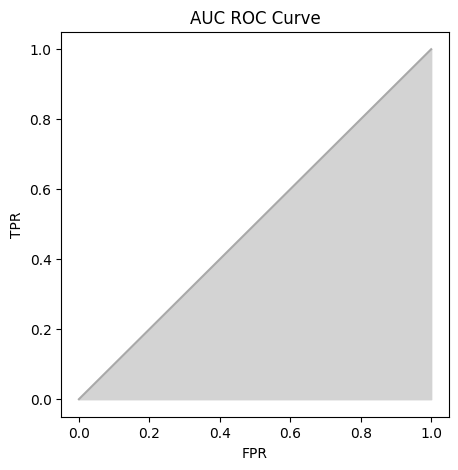

Baseline model - Test data performance


Confusion matrix :
 [[    0  6666]
 [    0 13334]]


Classification report :
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      6666
           1       0.67      1.00      0.80     13334

    accuracy                           0.67     20000
   macro avg       0.33      0.50      0.40     20000
weighted avg       0.44      0.67      0.53     20000


Accuracy score : 0.6667

AUC-ROC Value : 0.5


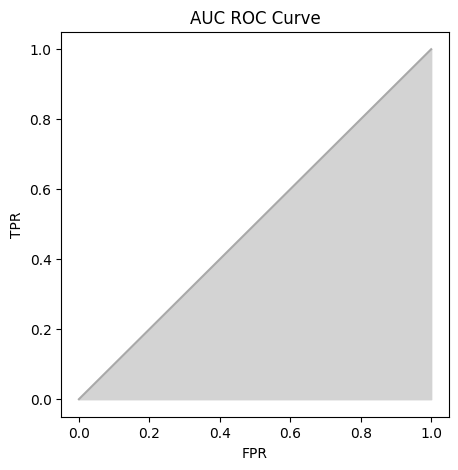

In [128]:
# baseline model

model = DummyClassifier(strategy='most_frequent').fit(x_train_scaled,y_train)
y_train_predict = model.predict(x_train_scaled)
y_test_predict = model.predict(x_test_scaled)

print("Baseline model - Train data performance")
model_performance(y_train,y_train_predict)
print("Baseline model - Test data performance")
model_performance(y_test,y_test_predict)

In [18]:
mod = XGBClassifier()
mod

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [21]:
models = {
    'lr':LogisticRegression()
    ,'rf':RandomForestClassifier()
    ,'knn':KNeighborsClassifier()
    ,'svc':SVC()
    ,'xgb':XGBClassifier()
}
params = {
    'lr':{
        'C':[0.1,1]
    },
    'rf':{
        'n_estimators':[100,200]
    },
    'knn':{
        'n_neighbors':[3,4,5,6,7]
    },
    'svc':{
        'C':[0.001,0.1]
        ,'kernel':['rbf','poly']
    },
    'xgb':{
        'n_estimators':[100,200]
        ,'learning_rate':[0.01,0.1,0.3]
        ,'gamma':[0,1,10]
    }

}
search = HyperclassifierSearch(models,params)
best_model = search.train_model(x_train_scaled,y_train,cv=2)

# Printing the best estimator and best parameters
print('\n\n',f'Best estimator and its parameters : {best_model.best_estimator_}','\n\n')
search.evaluate_model().sort_values(by='mean_test_score',ascending=False).style

Search for lr ...
Search for rf ...
Search for knn ...
Search for svc ...
Search for xgb ...
Search is done.


 Best estimator and its parameters : XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=10, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) 


results round for: lr
results round for: rf
results round for: knn
results round for: svc
resul

,Estimator,params,split0_test_score,split1_test_score,mean_test_score,std_test_score
0,xgb,"{'gamma': 10, 'learning_rate': 0.1, 'n_estimators': 200}",0.792000,0.789500,0.790750,0.001250
1,xgb,"{'gamma': 10, 'learning_rate': 0.1, 'n_estimators': 100}",0.792000,0.789500,0.790750,0.001250
2,xgb,"{'gamma': 10, 'learning_rate': 0.3, 'n_estimators': 200}",0.791500,0.789050,0.790275,0.001225
3,xgb,"{'gamma': 10, 'learning_rate': 0.3, 'n_estimators': 100}",0.791500,0.789050,0.790275,0.001225
4,xgb,"{'gamma': 10, 'learning_rate': 0.01, 'n_estimators': 200}",0.790675,0.789000,0.789837,0.000837
5,xgb,"{'gamma': 1, 'learning_rate': 0.1, 'n_estimators': 200}",0.789300,0.789250,0.789275,0.000025
6,xgb,"{'gamma': 1, 'learning_rate': 0.1, 'n_estimators': 100}",0.789300,0.789250,0.789275,0.000025
7,xgb,"{'gamma': 1, 'learning_rate': 0.01, 'n_estimators': 200}",0.789825,0.788275,0.789050,0.000775
8,xgb,"{'gamma': 0, 'learning_rate': 0.01, 'n_estimators': 200}",0.789625,0.788125,0.788875,0.000750
9,xgb,"{'gamma': 1, 'learning_rate': 0.3, 'n_estimators': 200}",0.789575,0.787975,0.788775,0.000800


Train data accuracy : 0.79
Test data accuracy : 0.79


Confusion matrix :
 [[ 4634  2032]
 [ 2103 11231]]


Classification report :
               precision    recall  f1-score   support

           0       0.69      0.70      0.69      6666
           1       0.85      0.84      0.84     13334

    accuracy                           0.79     20000
   macro avg       0.77      0.77      0.77     20000
weighted avg       0.79      0.79      0.79     20000


Accuracy score : 0.79325

AUC-ROC Value : 0.7687262014037012


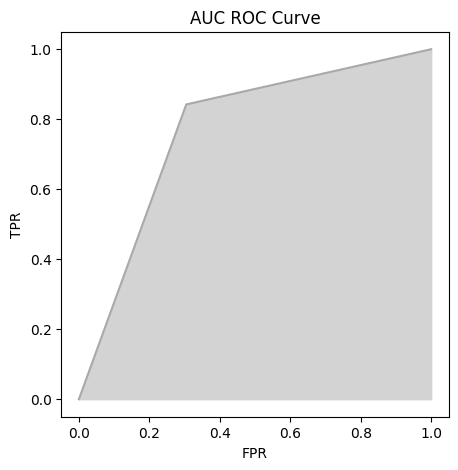

In [22]:
estimator = best_model.best_estimator_
model = estimator.fit(x_train_scaled,y_train)
y_train_predict = model.predict(x_train_scaled)
y_test_predict = model.predict(x_test_scaled)

# checking train accuracy and test accuracy
print(f'Train data accuracy : {model.score(x_train_scaled,y_train):.2f}')
print(f'Test data accuracy : {model.score(x_test_scaled,y_test):.2f}')

# complete model performance - test data
model_performance(y_test,y_test_predict)

Explain model features

PDP - Partial dependence plots

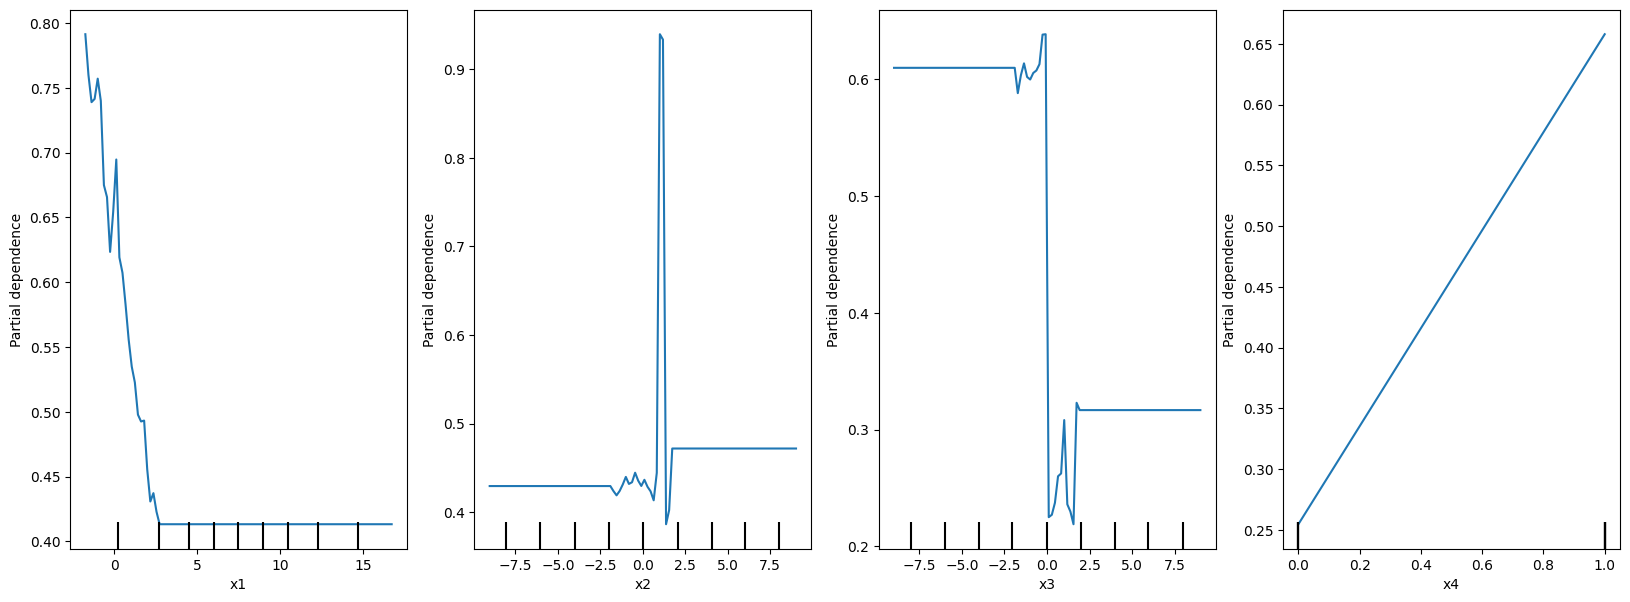

In [191]:
# PDP Plots

fig, ax = plt.subplots(1,4, figsize=(20,7), sharey=True)
for i,feature in enumerate(x_test.columns.to_list()):
    PDP.from_estimator(model,x_test,features=feature.split(','),feature_names=list(x_test.columns),ax=ax[i])
plt.show()

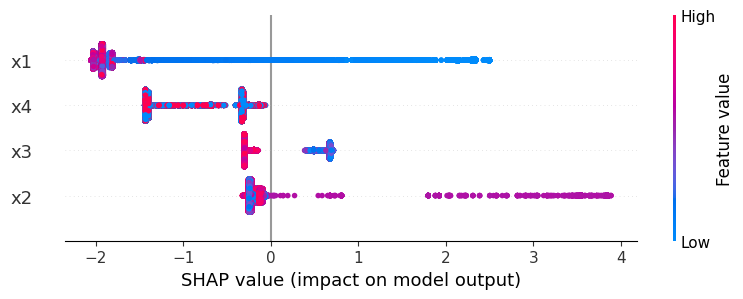

In [24]:
import shap
explainer = shap.TreeExplainer(model)
shap.summary_plot(explainer.shap_values(x),x)